In [1]:
import pandas as pd
from sklearn.svm import SVC
from collections import defaultdict
import json
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", message=".*tight_layout.*")


#### Load data and transform them to z-scores

In [2]:
# Load data and transform them (z-score)
dfs = dict()
for lang in ('cs', 'de', 'en', 'fr', 'it', 'ru'):
    dfs[lang] = pd.read_csv(
        f'data/{lang}.csv', 
        index_col=['@qid', '@author', '@zodiac', '@codiac', '@year', '@month', '@day', '@sample'],
        low_memory=False,    
    )
    dfs[lang] = dfs[lang].div(dfs[lang].sum(axis=1), axis=0)   
    dfs[lang] = (dfs[lang] - dfs[lang].mean())/dfs[lang].std(ddof=0)

#### Perform classifications

In [3]:
def _balance_classes(df, system='zodiac'):
    '''
    Balance dataframe so that each zodiac/codiac sign has the same number of rows
    '''
    min_count = df.groupby(level=f'@{system}').size().min()
    df = (
        df.groupby(level=f'@{system}').apply(lambda x: x.sample(n=min_count))
    )    
    df.index = df.index.droplevel(0)
    return df


def classify(X_train, X_test, y_train, y_test):
    '''
    Perform classification with SVM and return accuracy
    '''
    clf = SVC(kernel='linear', C=1)
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    t, f = 0, 0
    for pred, real in zip(predicted, y_test):
        if pred == real:
            t += 1
        else:
            f += 1
    return t/(t+f)


def trim_mft(df, mft):
    '''
    Trim dataframe to required number of most frequent types
    '''
    return df.iloc[: , :mft].fillna(0)


def downsample_authors(df, samples_per_author):
    '''
    Downsample authors (so that we don't get single-author train/test sets)
    '''
    df = (
        df.groupby(level='@author').apply(lambda x: x.sample(n=min(samples_per_author, len(x))))
    )   
    df.index = df.index.droplevel(0)
    return df


def train_test_split(df, system):
    '''
    Split data to train and test set by odd/even year when author born
    (if system == 'zodiac') or by odd/even decade when author born (if system
    == 'codiac') + balance classes both in
    '''

    df = df[~df.index.get_level_values(f'@{system}').isna()]
    if system == 'zodiac':
        X1 = df[df.index.get_level_values('@year') % 2 == 0]
        X2 = df[df.index.get_level_values('@year') % 2 != 0]
    elif system == 'codiac':
        X1 = df[df.index.get_level_values('@year') // 10 % 2 == 0]
        X2 = df[df.index.get_level_values('@year') // 10 % 2 != 0]
    X1 = _balance_classes(X1, system)
    X2 = _balance_classes(X2, system)
    y1 = X1.index.get_level_values(f'@{system}')
    y2 = X2.index.get_level_values(f'@{system}')
    return X1, X2, y1, y2


In [4]:
# Perform a battery of classifications over different systems (zodiac/codiac) and
# different levels of most frequent types 

mfts               = (100, 250, 500, 1000, 2500, 5000, 10000)   # Most frequent types levels
iterations         = 100                                        # Number of iterations per MFT level
samples_per_author = 5                                          # Maximum number of samples per author in train/test set

output = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for lang in dfs:
    for mft in mfts:
        for iter_ in range(iterations):
            print(f'LANG = {lang} | MFT = {mft} | ITER = {iter_}     ', end='\r')
            df = trim_mft(dfs[lang], mft)
            df = downsample_authors(df, samples_per_author)

            X1, X2, y1, y2 = train_test_split(df, 'zodiac')
            output['zodiac'][lang][mft].append(classify(X1, X2, y1, y2))
            output['zodiac'][lang][mft].append(classify(X2, X1, y2, y1))

            X1, X2, y1, y2 = train_test_split(df, 'codiac')
            output['codiac'][lang][mft].append(classify(X1, X2, y1, y2))
            output['codiac'][lang][mft].append(classify(X2, X1, y2, y1))

for system in output:
    with open(f'data/acc_{system}.json', 'w') as f:
        json.dump(output[system], f)

#### Visualize accuracy

In [5]:
def ridgeplot(data, title, vline=None, xlim=None):
    '''
    Make ridgeplot. Data is dataframe holding two columns 'x' and 'y'
    '''
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(data, row="y", hue="y", aspect=15, height=.5, palette=pal)
    g.map(sns.kdeplot, "x",
        bw_adjust=.5, clip_on=False,
        fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
    g.map(label, "x")
    g.figure.subplots_adjust(hspace=-.25)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    g.figure.suptitle(title, fontsize=16)
    if vline is not None:
        for ax in g.axes.flat:
            ax.axvline(x=vline, color='red', linestyle='--', linewidth=1.5)
    if xlim is not None:
        for ax in g.axes.flat:
            ax.set_xlim(xlim)
    plt.show()    

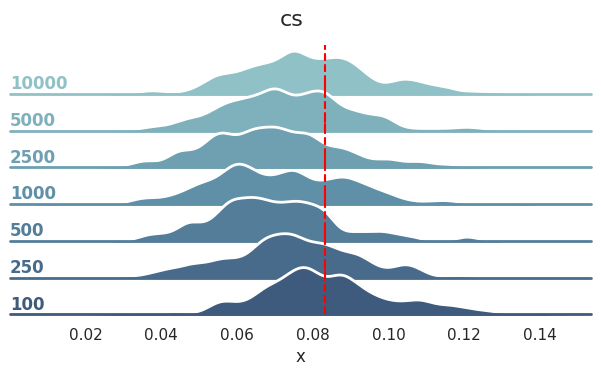

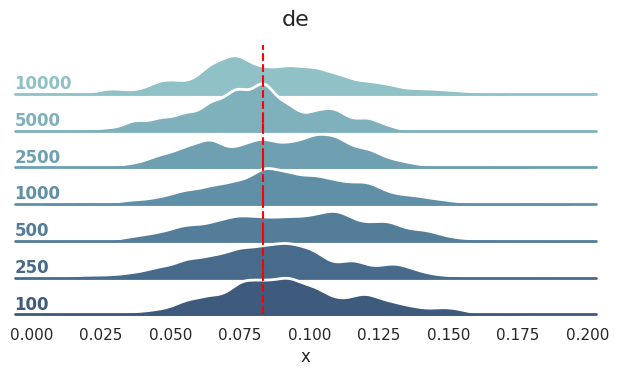

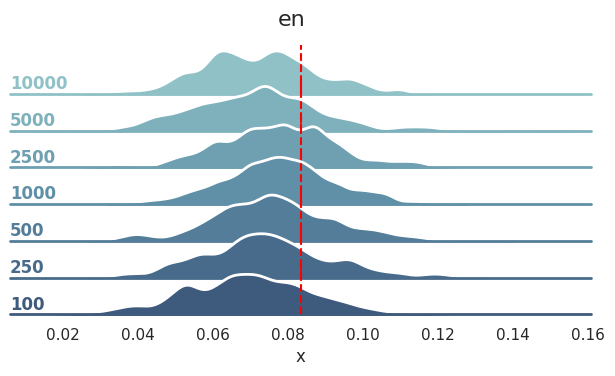

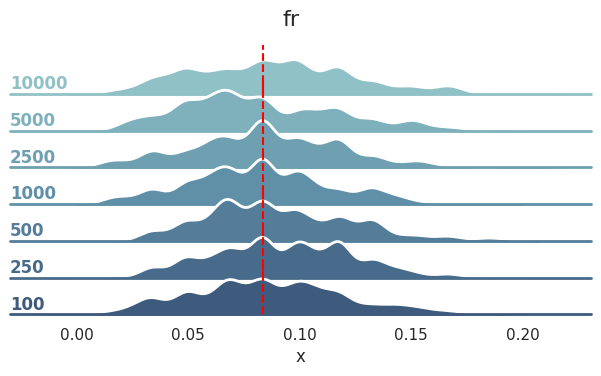

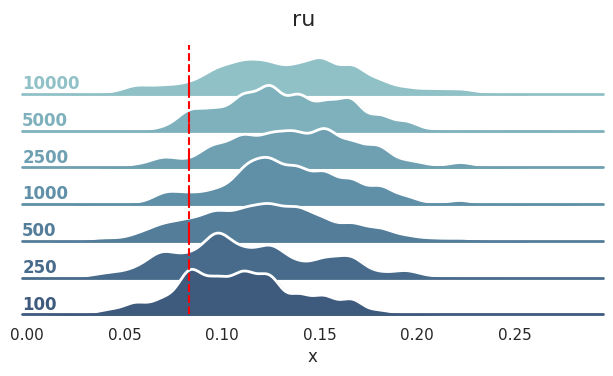

In [6]:
# Zodiac accuracy
with open('data/acc_zodiac.json') as f:
    output = json.load(f)
for lang in output:
    if lang == 'it': # Not enough data (trained on single samples)
        continue
    accs = []
    for mft in reversed([str(x) for x in mfts]):
        for x in output[lang][mft]:
            accs.append([x, mft])
    accs = pd.DataFrame(accs, columns=['x', 'y'])
    ridgeplot(accs, lang, vline=1/12)

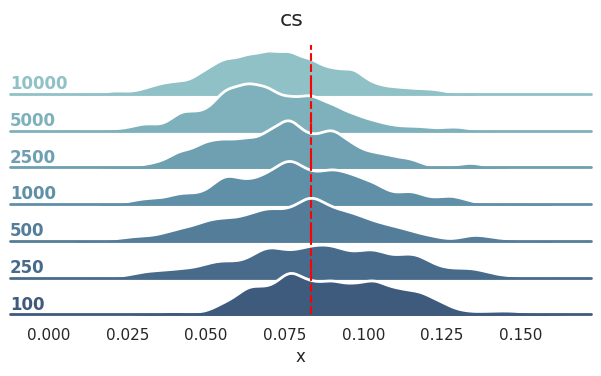

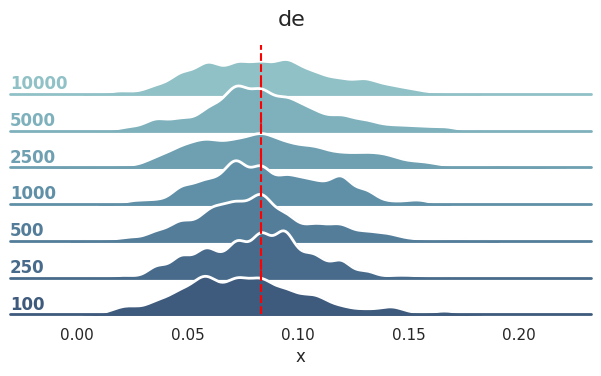

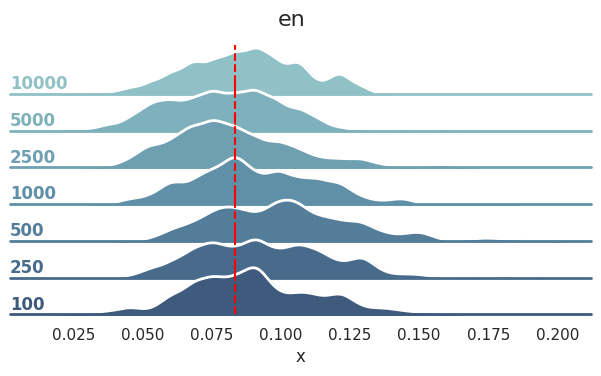

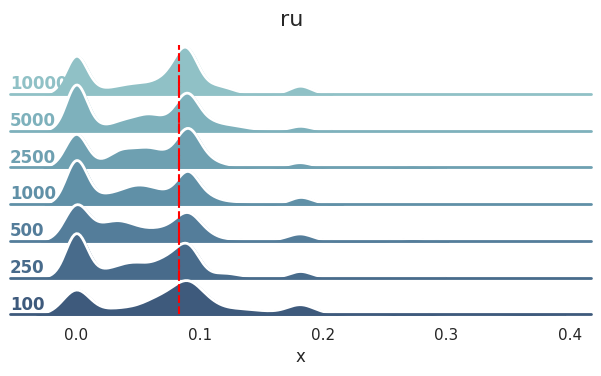

In [7]:
# Codiac accuracy
with open('data/acc_codiac.json') as f:
    output = json.load(f)
for lang in output:
    if lang in ('fr', 'it'): # Not enough data (trained on single samples)
        continue
    accs = []
    for mft in reversed([str(x) for x in mfts]):
        for x in output[lang][mft]:
            accs.append([x, mft])
    accs = pd.DataFrame(accs, columns=['x', 'y'])
    ridgeplot(accs, lang, vline=1/12)

#### Confusion matrices

In [8]:
def _confusion(X_train, X_test, y_train, y_test, cm):
    '''
    Build confusion matrix from single classification run
    and sum it up with other confusion matrices
    '''
    clf = SVC(kernel='linear', C=1)
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    for pred, real in zip(predicted, y_test):
        cm[real+'_'][pred] += 1
    return cm


def build_confusion_matrix(dfs, lang, mfts, iterations, samples_per_author):
    '''
    Build confusion matrix for selected language across selected
    most frequent type levels and selected number of iterations
    '''

    cm = defaultdict(lambda: defaultdict(int))
    for mft in mfts:
        for iter_ in range(iterations):
            df = trim_mft(dfs[lang], mft)
            df = downsample_authors(df, samples_per_author)
            X1, X2, y1, y2 = train_test_split(df, 'zodiac')
            cm = _confusion(X1, X2, y1, y2, cm)
            cm = _confusion(X2, X1, y2, y1, cm)
    cm = pd.DataFrame(cm).T.fillna(0).sort_index().sort_index(axis=1)
    sns.heatmap(cm, annot=True, fmt="g")


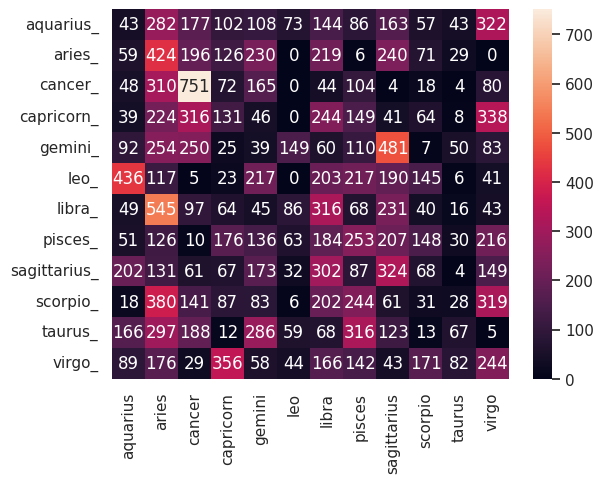

In [9]:
# Confusion matrix Russian
build_confusion_matrix(
    dfs                = dfs,
    lang               = 'ru', 
    mfts               = (1000,), 
    iterations         = 100,
    samples_per_author = 5
)

#### Zodiac distribution over time

In [10]:
def zodiac_in_time(dfs, lang, xlim):
    '''

    '''
    df = dfs[lang].reset_index().drop_duplicates(subset='@qid').set_index(['@qid', '@author', '@zodiac', '@codiac', '@year', '@month', '@day', '@sample'])
    data = []
    for (qid, author, zodiac, codiac, year, month, day, sample), row in df.iterrows():
        data.append([year, zodiac])
    data = pd.DataFrame(data, columns=['x', 'y'])
    ridgeplot(data, lang, xlim=xlim)    

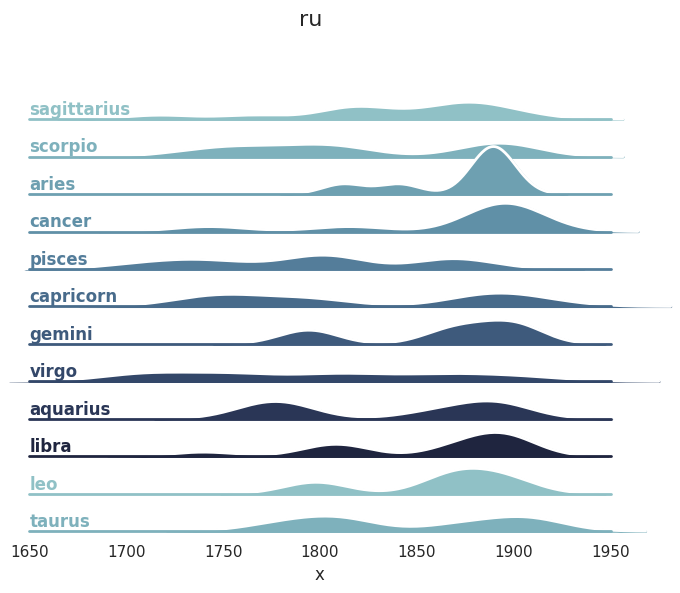

In [11]:
zodiac_in_time(dfs, 'ru', (1650,1950))

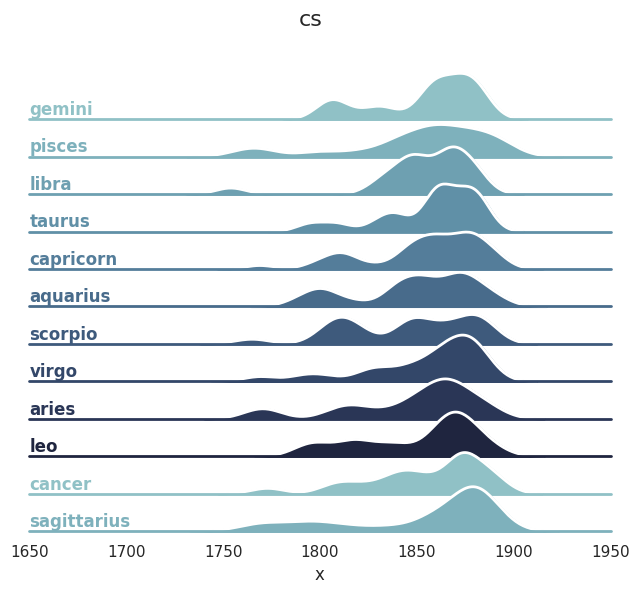

In [12]:
zodiac_in_time(dfs, 'cs', (1650,1950))